In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats.stats import pearsonr

In [2]:
plt.style.use('ggplot')

## load co2 data

- CO2 emissions in millions of tons

In [3]:
co2 = pd.read_excel("../data/bp-stats-review-2019-all-data.xlsx", "Carbon Dioxide Emissions", header=2)

In [4]:
co2.rename(columns={"Million tonnes of carbon dioxide":"country"}, inplace=True)

In [5]:
co2 = co2.loc[~(co2["country"].isnull() | co2["country"].str.contains("Total") | co2["country"].str.contains("OECD"))]

In [6]:
co2 = co2.set_index("country")
co2 = co2.stack().rename("co2").reset_index().rename(columns={"level_1":"year"})
co2 = co2.loc[co2["year"].astype(str).str.len() == 4]

In [7]:
co2.loc[:, "year"] = pd.to_numeric(co2.loc[:,"year"])
co2.loc[:, "co2"] = pd.to_numeric(co2.loc[:,"co2"])

In [8]:
co2.head()

,country,year,co2
0,Canada,1965,259.855545
1,Canada,1966,271.067865
2,Canada,1967,284.905440
3,Canada,1968,307.276993
4,Canada,1969,319.226620


## load energy data

- data contains the total energy consumption for each country per year in mtoe (millions tons of oil equivalent). this includes all energy sources

In [9]:
energy = pd.read_excel("../data/bp-stats-review-2019-all-data.xlsx", "Primary Energy Consumption", header=2)

In [10]:
energy.rename(columns={"Million tonnes oil equivalent":"country"}, inplace=True)

In [11]:
energy = energy.loc[~(energy["country"].isnull() | energy["country"].str.contains("Total") | energy["country"].str.contains("OECD"))]

In [12]:
energy = energy.set_index("country")
energy = energy.stack().rename("mtoe").reset_index().rename(columns={"level_1":"year"})
energy = energy.loc[energy["year"].astype(str).str.len() == 4]

In [13]:
energy.loc[:, "year"] = pd.to_numeric(energy.loc[:,"year"])
energy.loc[:, "mtoe"] = pd.to_numeric(energy.loc[:,"mtoe"])

In [14]:
energy.head()

,country,year,mtoe
0,Canada,1965,115.910849
1,Canada,1966,122.991657
2,Canada,1967,129.026541
3,Canada,1968,137.695457
4,Canada,1969,145.303023


### nuclear

- this is the amount of energy consumed that was from nuclear sources in mtoe (millions tons of oil equivalent)

In [15]:
nuc = pd.read_excel("../data/bp-stats-review-2019-all-data.xlsx", "Nuclear Consumption - Mtoe", header=2)

In [16]:
nuc.rename(columns={"Million tonnes oil equivalent":"country"}, inplace=True)

nuc = nuc.loc[~(nuc["country"].isnull() | nuc["country"].str.contains("Total") | nuc["country"].str.contains("OECD"))]

nuc = nuc.set_index("country")
nuc = nuc.stack().rename("mtoe").reset_index().rename(columns={"level_1":"year"})
nuc = nuc.loc[nuc["year"].astype(str).str.len() == 4]

nuc.loc[:, "year"] = pd.to_numeric(nuc.loc[:,"year"])
nuc.loc[:, "mtoe"] = pd.to_numeric(nuc.loc[:,"mtoe"])
nuc.rename(columns={"mtoe": "nuclear"}, inplace=True)
nuc.head()

,country,year,nuclear
0,Canada,1965,0.028963
1,Canada,1966,0.038919
2,Canada,1967,0.034620
3,Canada,1968,0.207721
4,Canada,1969,0.119700


## renewables

- amount of energy consumed from renewable sources in mtoe

In [18]:
renew = pd.read_excel("../data/bp-stats-review-2019-all-data.xlsx", "Renewables - Mtoe", header=2)

In [19]:
renew.rename(columns={"Million tonnes oil equivalent":"country"}, inplace=True)

In [20]:
renew = renew.loc[~(renew["country"].isnull() | co2["country"].str.contains("Total") | co2["country"].str.contains("OECD"))]

In [21]:
renew = renew.set_index("country")
renew = renew.stack().rename("mtoe").reset_index().rename(columns={"level_1":"year"})
renew = renew.loc[renew["year"].astype(str).str.len() == 4]

In [22]:
renew.loc[:, "year"] = pd.to_numeric(renew.loc[:,"year"])
renew.loc[:, "mtoe"] = pd.to_numeric(renew.loc[:,"mtoe"])
renew.rename(columns={"mtoe":"renewables"}, inplace=True)

In [23]:
renew = renew.merge(nuc, left_on=["country", "year"], right_on=["country", "year"])

In [24]:
energy = energy.merge(renew, left_on=["country", "year"], right_on=["country", "year"])

## shape data

- load in shape file data for each country and clean the country names in order to merge datasets.

In [25]:
df = co2.merge(energy, left_on=["country", "year"], right_on=["country", "year"])

In [26]:
df["country"] = df["country"].replace({"US": "United States", "Iran": "Iran (Islamic Republic of)",
                                       "South Korea": "Korea, Republic of", "China Hong Kong SAR": "Hong Kong",
                                       "Trinidad & Tobago": "Trinidad and Tobago", "Vietnam": "Viet Nam",
                                       "Russian Federation": "Russia"
                                      })

In [27]:
df["renew_ratio"] = (df["renewables"] + df["nuclear"]) / df["mtoe"]
df["emission_ratio"] = df["co2"]/df["mtoe"]

In [28]:
df.head()

,country,year,co2,mtoe,renewables,nuclear,renew_ratio,emission_ratio
0,Canada,1965,259.855545,115.910849,0.0,0.028963,0.000250,2.241857
1,Canada,1966,271.067865,122.991657,0.0,0.038919,0.000316,2.203953
2,Canada,1967,284.905440,129.026541,0.0,0.034620,0.000268,2.208115
3,Canada,1968,307.276993,137.695457,0.0,0.207721,0.001509,2.231570
4,Canada,1969,319.226620,145.303023,0.0,0.119700,0.000824,2.196972


In [31]:
countries = gpd.read_file("../data/shape_files/TM_WORLD_BORDERS-0.3.shp")

In [32]:
df.loc[~df["country"].isin(countries["NAME"])]["country"].value_counts()

                 European Union #    54
Western Africa                       54
Other South America                  54
Other Caribbean                      54
Eastern Africa                       54
Other Northern Africa                54
Central America                      54
Other Europe                         54
Other Middle East                    54
Middle Africa                        54
Other Asia Pacific                   54
Other CIS                            34
USSR                                 20
Name: country, dtype: int64

In [33]:
df1 = df.merge(countries, left_on="country", right_on="NAME")

### Emission analysis

In [34]:
df.head()

,country,year,co2,mtoe,renewables,nuclear,renew_ratio,emission_ratio
0,Canada,1965,259.855545,115.910849,0.0,0.028963,0.000250,2.241857
1,Canada,1966,271.067865,122.991657,0.0,0.038919,0.000316,2.203953
2,Canada,1967,284.905440,129.026541,0.0,0.034620,0.000268,2.208115
3,Canada,1968,307.276993,137.695457,0.0,0.207721,0.001509,2.231570
4,Canada,1969,319.226620,145.303023,0.0,0.119700,0.000824,2.196972


In [35]:
df["renew_ratio"].max()

0.4419152986729476

Text(0.5, 1, '2018')

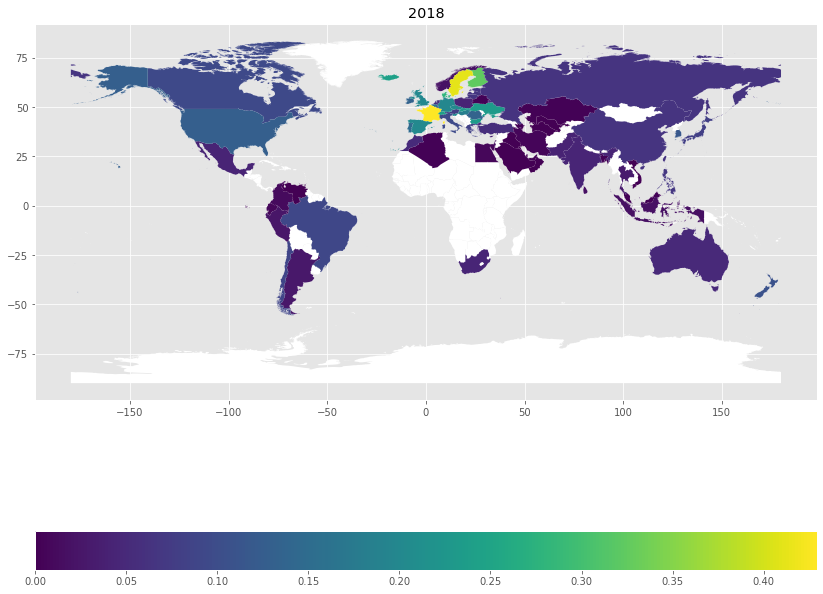

In [36]:
vmin = 0
vmax = .5
# for year in range(1990, 2019):
year = 2018

ax = countries.plot(color='white', figsize=(14, 16))

gpd.GeoDataFrame(df1.loc[df1["year"]==year]).plot(column="renew_ratio", ax=ax, legend=True, 
                                              legend_kwds={'orientation': "horizontal"},
                                              # norm=plt.Normalize(vmin=vmin, vmax=vmax)
                                             )

plt.title(year)
# filepath = os.path.join("output/", str(year)+'.jpg')
# chart = ax.get_figure()
# chart.savefig(filepath, dpi=100)
# ax.clear()

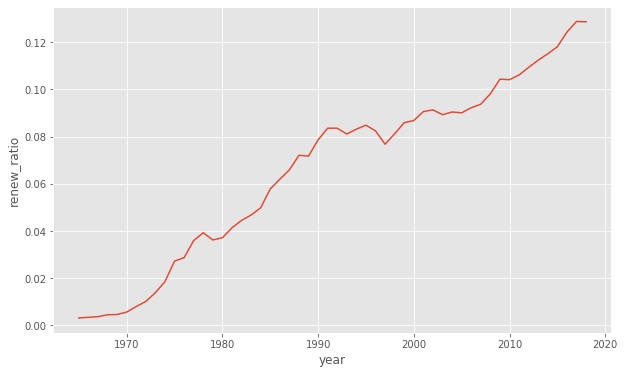

In [37]:
plt.figure(figsize=(10,6))
sns.lineplot(x="year", y="renew_ratio", data=df.loc[df["country"] == "United States"])
plt.show()

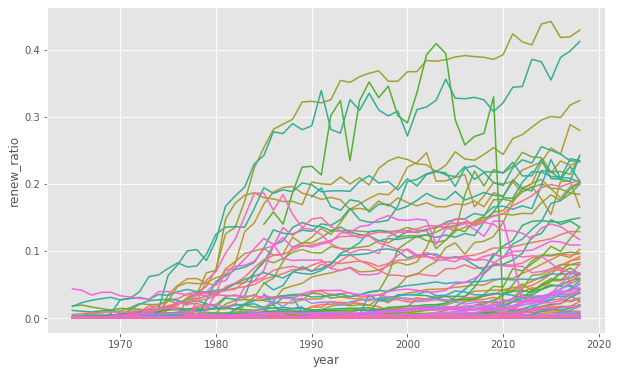

In [38]:
plt.figure(figsize=(10,6))
sns.lineplot(x="year", y="renew_ratio", hue="country", data=df, legend=False)
plt.show()

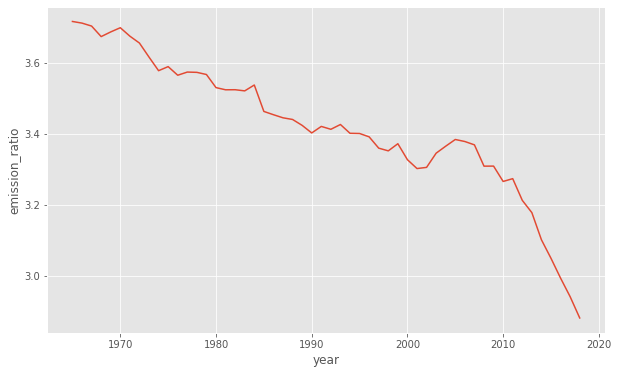

In [39]:
plt.figure(figsize=(10,6))
sns.lineplot(x="year", y="emission_ratio", data=df.loc[df["country"] == "China"])
plt.show()

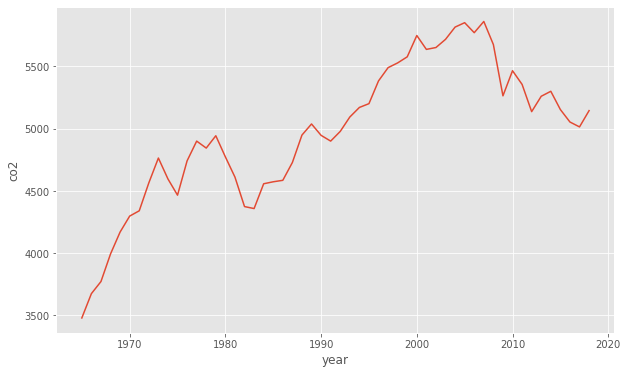

In [40]:
plt.figure(figsize=(10,6))
sns.lineplot(x="year", y="co2", data=df.loc[df["country"] == "United States"])
plt.show()

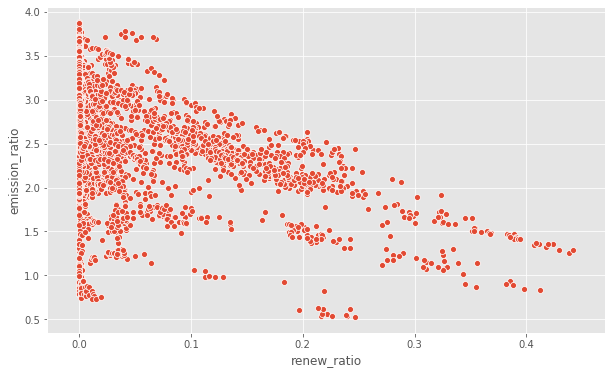

In [41]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="renew_ratio", y="emission_ratio", data=df)
plt.show()

## ignore this stuff

In [43]:
df2 = pd.read_csv("../data/AIR_GHG_25112019164912870.csv")
# df2.head()

In [26]:
df2["Country"] = df2["Country"].replace({"United States":"US", "Russia":"USSR", 
                                         "Slovak Republic":"Slovakia", "Korea": "South Korea",
                                         "China (People's Republic of)":"China"
                                        })

In [27]:
df2 = df2.loc[(df2["POL"] == "GHG") & (df2["VAR"] == "TOTAL")]

In [31]:
df3 = energy.merge(df2, left_on=["country", "year"], right_on=["Country", "Year"]).loc[:,["country", "year", "Value", "mtoe", "renewables"]]

In [32]:
df3.head()

,country,year,Value,mtoe,renewables
0,Canada,1990,602184.441,248.959371,0.895126
1,Canada,1991,593402.355,249.176780,0.901914
2,Canada,1992,610440.864,255.459400,1.024133
3,Canada,1993,612264.416,261.004881,1.103782
4,Canada,1994,633675.452,270.622255,1.311050


In [34]:
df3["renew_ratio"] = df3["renewables"] / df3["mtoe"]
df3["emission_ratio"] = df3["Value"]/df3["mtoe"]

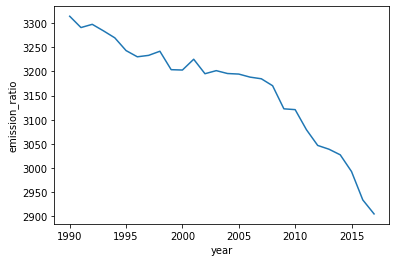

In [40]:
sns.lineplot(x="year", y="emission_ratio", data=df3.loc[df3["country"] == "US"])

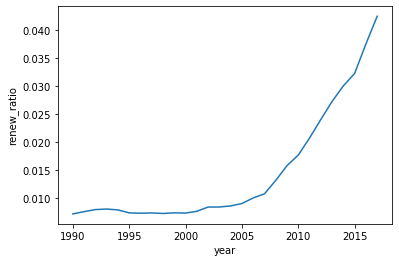

In [41]:
sns.lineplot(x="year", y="renew_ratio", data=df3.loc[df3["country"] == "US"])

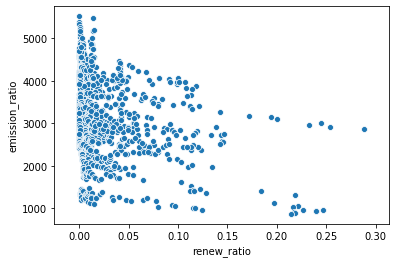

In [38]:
sns.scatterplot(x="renew_ratio", y="emission_ratio", data=df3)